# RGB-based 3D Reconstruction using Stereo image

## Import

In [1]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
import cv2
import matplotlib.pyplot as plt
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load stereo images

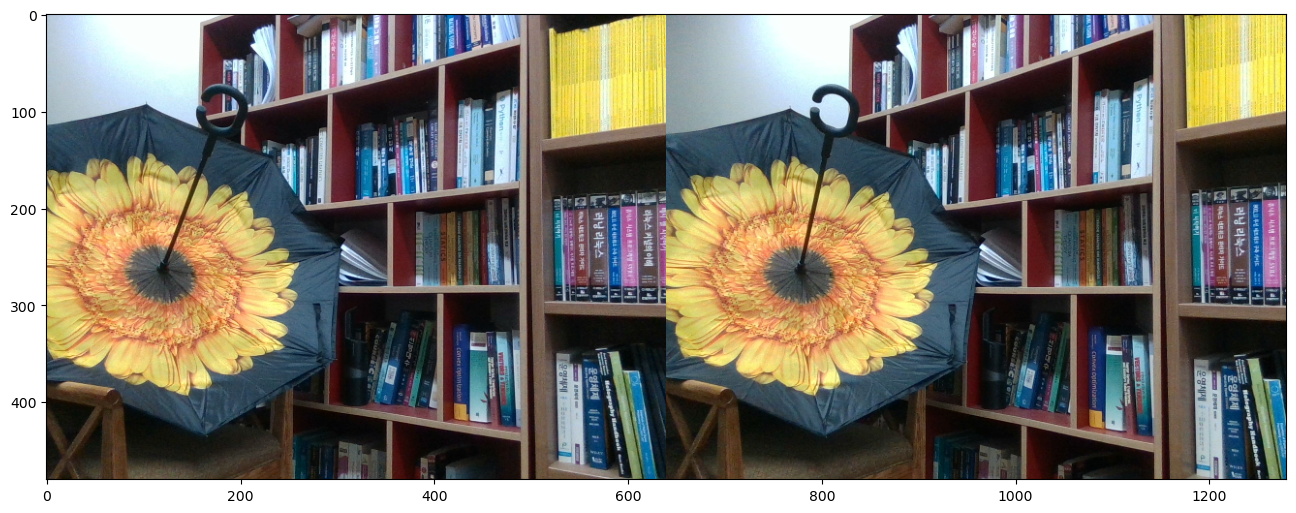

In [2]:
rgb_left = cv2.imread('left.png', 1)
rgb_right = cv2.imread('right.png', 1)

img_concat = cv2.hconcat([rgb_left, rgb_right])
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

h, w, ch = rgb_left.shape

## Set Camera Intrinsic parameter

In [3]:
f_x = 618.212
f_y = 617.673
c_x = 323.716
c_y = 256.977
k1 = 0
k2 = 0

K = np.array([[f_x, 0, c_x], [0, f_y, c_y], [0, 0, 1]], dtype=np.float64)
dist = np.array([[0, 0, 0, 0, 0]], dtype=np.float64)

print(K)
print(dist)

[[618.212   0.    323.716]
 [  0.    617.673 256.977]
 [  0.      0.      1.   ]]
[[0. 0. 0. 0. 0.]]


## Undistortion

### 1. Using cv2.undistort()

In [4]:
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))

In [9]:
# Undistort
dst_left = cv2.undistort(rgb_left, K, dist, None, newcameramtx)
dst_right = cv2.undistort(rgb_right, K, dist, None, newcameramtx)

# Crop the image
x, y, w, h = roi
dst_left = dst_left[y:y+h, x:x+w]
dst_right = dst_right[y:y+h, x:x+w]

cv2.imwrite('dst_left.png', dst_left)
cv2.imwrite('dst_right.png', dst_right)

True

### 2. Using remapping

In [ ]:
# Undistort
mapx, mapy = cv2.initUndistortRectifyMap(K, dist, None, newcameramtx, (w, h), 5)
dst_left = cv2.remap(rgb_left, mapx, mapy, cv2.INTER_LINEAR)
dst_right = cv2.remap(rgb_right, mapx, mapy, cv2.INTER_LINEAR)

# crop the image
x, y, w, h = roi
dst_left = dst_left[y:y+h, x:x+w]
dst_right = dst_right[y:y+h, x:x+w]

cv2.imwrite('dst_left.png', dst_left)
cv2.imwrite('dst_right.png', dst_right)

## SIFT Feature matching

### Feature Extraction

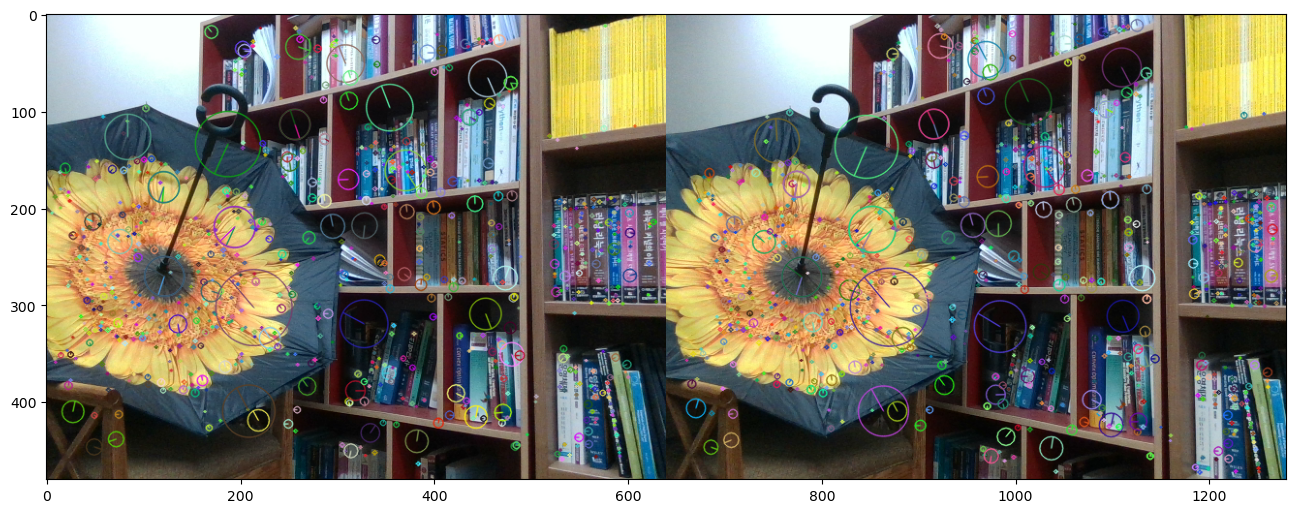

In [9]:
img1 = rgb_left
img2 = rgb_right

sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

nkp1 = []
ndesc1 = []
nkp2 = []
ndesc2 = []
pts1 = []
pts2 = []
good = []
kkp1 = []
kkp2 = []

max_x1 = 640
min_x1 = 0
max_y1 = 480
min_y1 = 0

for i in range(len(kp1)):
    if kp1[i].pt[0] < max_x1 and kp1[i].pt[0] > min_x1 and kp1[i].pt[1] < max_y1 and kp1[i].pt[1] > min_y1:
        nkp1.append(kp1[i])
        ndesc1.append(des1[i])

for i in range(len(kp2)):
    if kp2[i].pt[0] < max_x1 and kp2[i].pt[0] > min_x1 and kp2[i].pt[1] < max_y1 and kp2[i].pt[1] > min_y1:
        nkp2.append(kp2[i])
        ndesc2.append(des2[i])

nkp1 = tuple(nkp1)
nkp2 = tuple(nkp2)
ndesc1 = tuple(ndesc1)
ndesc2 = tuple(ndesc2)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(np.asarray(ndesc1, np.float32), np.asarray(ndesc2, np.float32), k=2)
for i,(m,n) in enumerate(matches):
    if m.distance < 0.75 * n.distance:
        pts1.append(nkp1[m.queryIdx].pt)
        pts2.append(nkp2[m.trainIdx].pt)
        kkp1.append(nkp1[m.queryIdx])
        kkp2.append(nkp2[m.trainIdx])
        good.append([m])

img_k1 = img1.copy()
cv2.drawKeypoints(img_k1, kkp1, img_k1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_k2 = img2.copy()
cv2.drawKeypoints(img_k2, kkp2, img_k2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

res = cv2.hconcat([img_k1, img_k2])
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))


### Feature matching

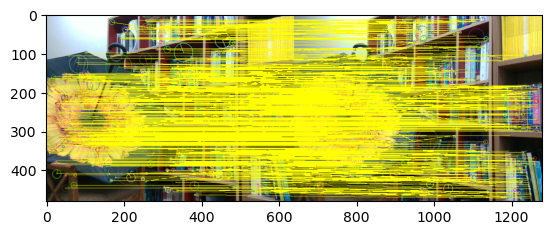

In [10]:
for i in range(len(pts1)):
    cv2.line(res, (int(pts1[i][0]), int(pts1[i][1])), (int(pts2[i][0])+w, int(pts2[i][1])), (0, 255, 255), 1, 4 )

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## Compute Essential Matrix

In [12]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

p1, p2 = np.ascontiguousarray(pts1, np.float32), np.ascontiguousarray(pts2, np.float32)

# Normalized points
pts1_norm = cv2.undistortPoints(np.expand_dims(p1, axis=1), cameraMatrix=K, distCoeffs=dist)
pts2_norm = cv2.undistortPoints(np.expand_dims(p2, axis=1), cameraMatrix=K, distCoeffs=dist)

# Essential matrix
E, mask = cv2.findEssentialMat(pts1_norm, pts2_norm, focal=1.0, pp=(0., 0.), method=cv2.RANSAC, prob=0.999, threshold=3.0/500.0)
E = E / E[2,2]

print('Essential Matrix')
print(E)

Essential Matrix
[[   2.82523459  155.66224432  -24.43560704]
 [-242.24682959   -2.79336917  657.93989901]
 [  26.75257102 -683.58551935    1.        ]]


## Get Rotation, translation

In [13]:
# Essential matrix로부터 Pose 계산

points, R_est, t_est, mask_pose = cv2.recoverPose(E, pts1_norm, pts2_norm)

print('Rotation')
print(R_est)

print('translation')
print(t_est)

Rotation
[[ 0.99168349  0.00220143  0.1286818 ]
 [-0.00264444  0.99999115  0.00327194]
 [-0.12867345 -0.00358502  0.99168054]]
translation
[[-0.97444452]
 [-0.03585342]
 [-0.22174851]]


## Stereo Rectification

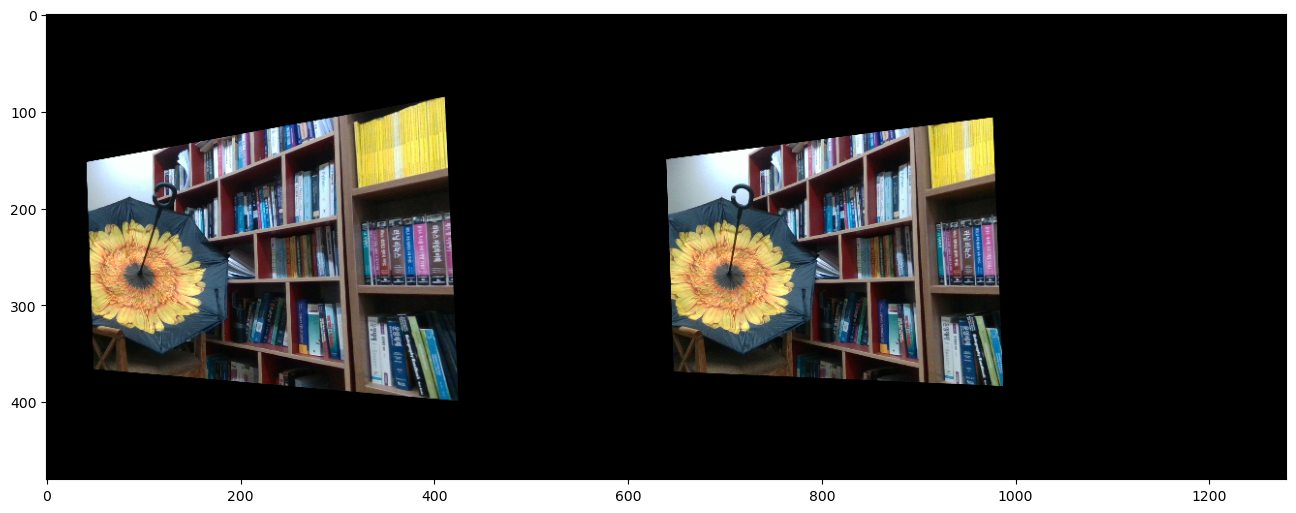

In [21]:
R = R_est
T = t_est

R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(cameraMatrix1=K,
                                                  distCoeffs1=dist,
                                                  cameraMatrix2=K,
                                                  distCoeffs2=dist,
                                                  imageSize=(w, h),
                                                  R=R, T=T,
                                                  flags=cv2.CALIB_ZERO_DISPARITY,
                                                  alpha=1)

map1_x, map1_y = cv2.initUndistortRectifyMap(
    cameraMatrix=K, distCoeffs=dist, R=R1, newCameraMatrix=P1, size=(w, h), m1type=cv2.CV_32FC1)

map2_x, map2_y = cv2.initUndistortRectifyMap(
    cameraMatrix=K, distCoeffs=dist, R=R2, newCameraMatrix=P2, size=(w, h), m1type=cv2.CV_32FC1)

img1_rect = cv2.remap(rgb_left, map1_x, map1_y, cv2.INTER_LINEAR)
img2_rect = cv2.remap(rgb_right, map2_x, map2_y, cv2.INTER_LINEAR)

plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(cv2.hconcat([img1_rect, img2_rect]), cv2.COLOR_BGR2RGB))

## Stereo matching

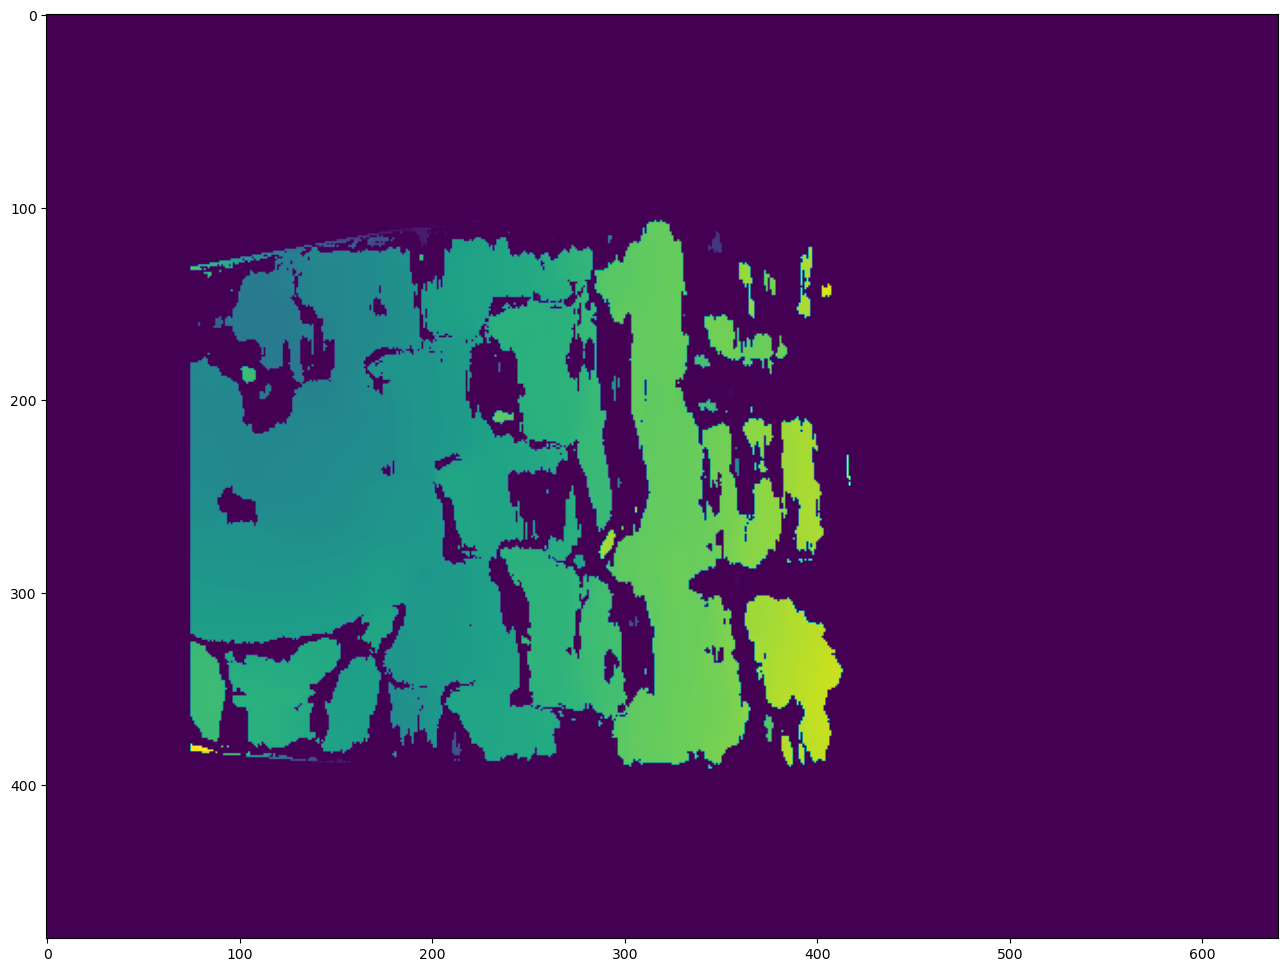

In [26]:
# Convert image to grayscale before matching
grayL = cv2.cvtColor(img1_rect, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(img2_rect, cv2.COLOR_BGR2GRAY)

stereo = cv2.StereoBM_create(numDisparities=64, blockSize=25)
disparity = stereo.compute(grayL, grayR) / 10

plt.figure(figsize=(16, 12))
plt.imshow(disparity)


## 3D Reconstruction

In [ ]:
colors = []
points = []

f_x = K[0,0]
f_y = K[1,1]
c_x = K[0,2]
c_y = K[1,2]
# target distance unit: meter
Z = 1.0 

sampling_rate = 1

for v in range(0,h,sampling_rate):
  for u in range(0,w,sampling_rate):
    if disparity[v,u] < 0:
      continue
    color = img1_rect[int(v),int(u),:]
    if color[2] == 0 and color[1]==0 and color[0] == 0:
      continue
    Z = -T[0,0] * K[0,0] / disparity[v,u]
    if Z < 0 or Z > 10:
      continue
    X = (u - c_x) * Z / f_x
    Y = (v - c_y) * Z / f_y
    points.append([X,Y,Z])
    colors.append([color[2]/255.0, color[1]/255.0, color[0]/255.0])

points = np.array(points)
colors = np.array(colors)

print(type(points))
print(points.shape)

# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(points)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)

## Visualization & Save Point Clouds

In [ ]:
o3d.visualization.draw_geometries([pcd_o3d])

o3d.io.write_point_cloud('recon_rgb.ply', pcd_o3d)